# Analysis on Final Dataset

The main problem is that I have to go through multiple files and if each file naturally causes such high degree networks, it is good to initially ignore these and see if the static cut-off approach is correct!

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import pathlib
import glob

import json

import networkx as nx

import re
import uuid

Of course, there is always a slight change in the code which in the end makes it look repetative. Trying to avoid that

## Getting the information among all files

It is easy, but the original functions need to be changed and adjusted. We have to obtain the distinct authors for each file, combine them together check again for distinct authors again. It turns out that there are greek, russian an arabic people in it.

This cell gives it for individual files

In [2]:
def getUniqueAuthors(data, limit=20):
    """
    Get Unique Authors for given paper
    Needs to be done after each batch and another numpy.unique after that
    
    INPUT:
        data (json): contains publications information
    OUTPUT:
        temp_mem: contains unique authors from one batch.  
    
        
    """
    temp_mem = []
    r = re.compile(r"\s+", re.MULTILINE)
    count = 0
    for i in range(len(data['content'])):
        if ('authorships' in data['content'][i].keys() ) and (limit >= len(data['content'][i]['authorships'])):       #"yes, someone forgets to fill this"
            for j in range(len(data['content'][i]['authorships'])):
                if (data['content'][i]['authorships'][j]['otype'] == 'PersonAuthorship'):
                    string_to_add = '' 
                    if 'givenName' in data['content'][i]['authorships'][j]:
                        string_to_add += str(data['content'][i]['authorships'][j]['givenName']) + ' '
                    if 'familyName' in data['content'][i]['authorships'][j]:
                        string_to_add += str(data['content'][i]['authorships'][j]['familyName'])
                    if len(string_to_add) > 0:
                        temp_mem.append(r.sub("",string_to_add))


    temp_mem = np.array(list(np.unique(temp_mem)), dtype=object)   # define it as an object
    #temp_mem = dict(zip(temp_mem, np.array(np.arange(len(temp_mem)),dtype=np.uint32 )) ) 
    return temp_mem


def getAuthorLinks(data,temp_link_list,encoder, limit=20): 
    _name_list = np.array(list(encoder.keys()))            #saving tables
    _encoded_list = np.array(list(encoder.values())) 
    
    temp_link_list = np.zeros((0,4), dtype=np.uint32)
    r = re.compile(r"\s+", re.MULTILINE)                   #for stripping some stuff

    for i in range(len(data['content'])):
        if (i+1) % 10 == 0:
            sys.stdout.write("\r {0} / {1} # {2}".format(i+1,len(data['content']), len(temp_link_list)))
            sys.stdout.flush()
        content_mem = []
        if ('authorships' in data['content'][i].keys()) and (limit >= len(data['content'][i]['authorships'])):       #"yes, someone forgets to fill this"
            for j in range(len(data['content'][i]['authorships'])):

                if (data['content'][i]['authorships'][j]['otype'] == 'PersonAuthorship'):
                    name_to_add = ''
                    string_to_add = '' 
                    #if the field extists, get the name! -> what if none of them exists? don't give anything
                    if 'givenName' in data['content'][i]['authorships'][j]:
                        name_to_add += str(data['content'][i]['authorships'][j]['givenName']) + ' '
                    if 'familyName' in data['content'][i]['authorships'][j]:
                        name_to_add += str(data['content'][i]['authorships'][j]['familyName'])
                    name_to_add = r.sub("", name_to_add)
                    _encoded = _encoded_list[_name_list == name_to_add]
                    if len(_encoded) == 1:
                        content_mem.append(_encoded[0])
                    else:
                        print("Wrong amount of authors: {} != 1 !".format(len(_encoded)))

        if (len(content_mem) > 0):
            tmp_mem = []     #save partial results as constans addition is not liked by numpy
            for j in range(len(content_mem)):
                for k in np.arange(j+1,len(content_mem)):
                    tmp_mem.append([content_mem[j],
                                    content_mem[k],
                                    data['content'][i]['publishedYear'],
                                    len(data['content'][i]['authorships'])
                                   ]
                                  )
            if (len(tmp_mem) > 0): 
                temp_link_list = np.append(temp_link_list,
                                           tmp_mem,
                                           axis=0)

    temp_link_list = np.array(temp_link_list, dtype=np.uint32)
    return temp_link_list
    

This cell combines the results from individual file processing.

In [15]:
def getFilesUniqueAuthors(loc, limit=20):
    """
    Get Unique Authors for all batches, uses getUniqueAuthors
    
    INPUT:
        loc: path to the batches' folder
    OUTPUT:
        uniqueAuthorsEncoded: unique authors from all batches
    
    
    """
    uniqueAuthors = np.array([], dtype=object)   #initiate the container 
    files = os.listdir(loc)                      #get files in the given folder
    
    assert len(files) >= 1, "No files found! 1 >= {}".format(len(files))
    for i in range(len(files)):
        sub_path = loc + "/" + files[i]
        print(sub_path)
    
    for i in range(len(files)):
        #technically os.listdir lists everything in the folder, not only files 
        #i have to try to open them
        sub_path = loc + "/" + files[i]
        
        try:       
            file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
            data = json.load(file)                                      #use json library to open
            file.close()                                                #close immidiately
        except:
            print("Cannot open {}".format(sub_path))
            pass
        
        #proceed 
        batchUniqueAuthors = getUniqueAuthors(data, limit=limit)
        uniqueAuthors = np.append( uniqueAuthors, batchUniqueAuthors )

        sys.stdout.write("\rFILE: {}\t{}/{} -> {} / {}\t\t\t\t".format(sub_path,
                                                               i+1,
                                                               len(files),
                                                               len(batchUniqueAuthors),
                                                               len(uniqueAuthors)))
        sys.stdout.flush()

    
            
    
    #when finished, use np.unqiue again
    bashedAmount = len(uniqueAuthors)
    
    uniqueAuthors = np.unique(uniqueAuthors)
    uniqueAuthorsEncoded = dict(zip(uniqueAuthors, np.array(np.arange(len(uniqueAuthors)), dtype=np.uint32)))
    
    print("{} to {} actually exists".format(bashedAmount,len(uniqueAuthors)))
    return uniqueAuthorsEncoded

def getFilesAuthorLinks(loc, encoder, limit=20):
    """
    Gets links beteen Unique authors to 
    
    INPUT:
        temp_link_list: contains edges
        encoder: list with encoded unique authors
        limit: limit to ignore pubications by comparing to their authourCount
    
    OUTPUT:
        VOID: modifies temp_link_ist accordingly
    
    """
    tmp_lnk_lst = np.zeros((0,4), dtype=np.uint32)      #burning in datatype
    files = os.listdir(loc)
    
    for i in range(len(files)):
        #technically os.listdir lists everything in the folder, not only files 
        #i have to try to open them
        sub_path = loc + "/" + files[i]
        
        try:       
            file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
            data = json.load(file)                                      #use json library to open
            file.close()                                                #close immidiately
        except:
            print("Cannot open {}".format(sub_path))
            pass
        
        #proceed 
        batchAuthorLinks = getAuthorLinks(data=data, temp_link_list=tmp_lnk_lst, encoder=encoder, limit=limit)
        tmp_lnk_lst = np.append( tmp_lnk_lst, batchAuthorLinks, axis=0 )
        print("\tFILE: {}\t{}/{} -> {}/{}\t\t\t\t".format(sub_path,
                                                               i+1,
                                                               len(files),
                                                               len(batchAuthorLinks),
                                                               len(tmp_lnk_lst)
                                                               ))

    
    #it seems like here somehow self-loops are passed, so we should exclude them!
    tmp_lnk_lst = tmp_lnk_lst[~(tmp_lnk_lst[:,0] == tmp_lnk_lst[:,1])]
    
    return tmp_lnk_lst

In [10]:
path = "data/final"

_UniqueAuthors = getFilesUniqueAuthors(loc=path, limit=20)

data/final/publications_1.json
data/final/publications_10.json
data/final/publications_11.json
data/final/publications_12.json
data/final/publications_13.json
data/final/publications_14.json
data/final/publications_2.json
data/final/publications_3.json
data/final/publications_4.json
data/final/publications_5.json
data/final/publications_6.json
data/final/publications_7.json
data/final/publications_8.json
data/final/publications_9.json
FILE: data/final/publications_9.json	14/14 -> 7111 / 95824				95824 to 51450 actually exists


In [16]:
tmp_lnk_lst = getFilesAuthorLinks(loc=path, encoder = _UniqueAuthors, limit=20)

 5000 / 5000 # 27772	FILE: data/final/publications_1.json	1/14 -> 27773/27773				
 5000 / 5000 # 22276	FILE: data/final/publications_10.json	2/14 -> 22276/50049				
 5000 / 5000 # 28170	FILE: data/final/publications_11.json	3/14 -> 28191/78240				
 5000 / 5000 # 26406	FILE: data/final/publications_12.json	4/14 -> 26406/104646				
 5000 / 5000 # 26564	FILE: data/final/publications_13.json	5/14 -> 26585/131231				
 2160 / 2166 # 11484	FILE: data/final/publications_14.json	6/14 -> 11541/142772				
 5000 / 5000 # 24127	FILE: data/final/publications_2.json	7/14 -> 24127/166899				
 5000 / 5000 # 24434	FILE: data/final/publications_3.json	8/14 -> 24489/191388				
 5000 / 5000 # 23651	FILE: data/final/publications_4.json	9/14 -> 23651/215039				
 5000 / 5000 # 24124	FILE: data/final/publications_5.json	10/14 -> 24124/239163				
 5000 / 5000 # 25233	FILE: data/final/publications_6.json	11/14 -> 25233/264396				
 5000 / 5000 # 26957	FILE: data/final/publications_7.json	12/14 -> 26957/291353				

In [12]:
tmp_lnk_lst[0,:]

array([22082, 13837,  2014,     8], dtype=uint32)

In [13]:
len(tmp_lnk_lst)

338133

In [14]:
len(tmp_lnk_lst[(tmp_lnk_lst[:,0] == tmp_lnk_lst[:,1])])

0

Seems to be correct, let's progress with the original stuff

## Investigating MTID

In [19]:
mtid_cont = np.array([], dtype=np.uint32)
files = os.listdir(path)
loc = path
count = 0
    
for i in range(len(files)):

    sub_path = loc + "/" + files[i]
        
    try:       
        file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
        data = json.load(file)                                      #use json library to open
        file.close()                                                #close immidiately
    except:
        print("Cannot open {}".format(sub_path))
        pass
        
    #proceed 
    temp_mem = []
    for i in range(len(data['content'])):
        if 'authorships' in data['content'][i].keys():
            for j in range(len(data['content'][i]['authorships'])):
                if 'mtid' in data['content'][i]['authorships'][j].keys():
                    temp_mem.append(data['content'][i]['authorships'][j]['mtid'])
                    count+=1
                       
    mtid_cont = np.append(mtid_cont, np.unique(temp_mem) )

Cannot open data/final/publications_12.json
Cannot open data/final/publications_13.json
Cannot open data/final/publications_14.json
Cannot open data/final/publications_2.json
Cannot open data/final/publications_3.json
Cannot open data/final/publications_4.json


KeyboardInterrupt: 

In [16]:
asd = np.unique(mtid_cont)
len(asd)

2405149

In [18]:
mtid_cont.shape

(2405149,)

In [21]:
print(count)

2405149


This means that mtid is unique in some different way, but cannot be used as a way to encode the different authors.

# Indicators

## Degree Distribution

In [18]:
#create the grahp object
sample_graph = nx.Graph()
sample_graph.add_edges_from(tmp_lnk_lst[:,0:2])

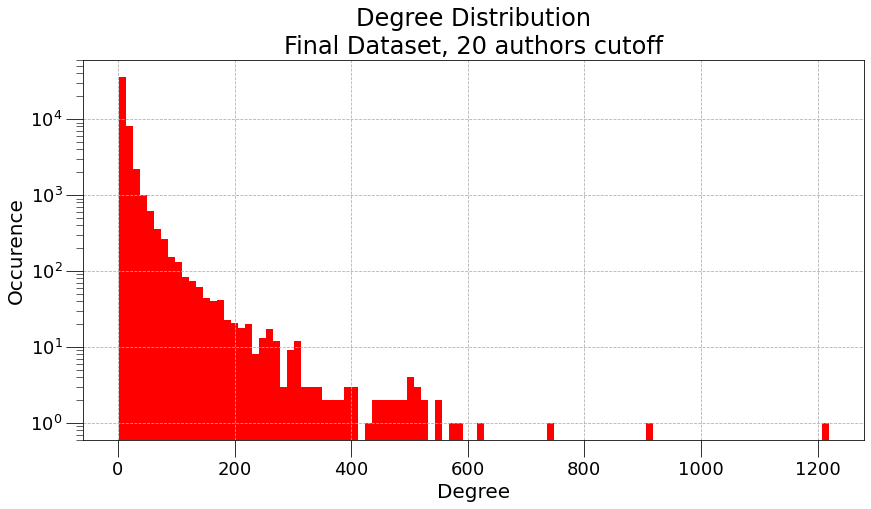

In [239]:
plt.figure(figsize=(14,7))

plt.title("Degree Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

_, deg = np.unique(tmp_lnk_lst[:,0:2].flatten(), return_counts=True)
plt.hist(deg, bins=101, color="red")

plt.xlabel("Degree", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/k_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

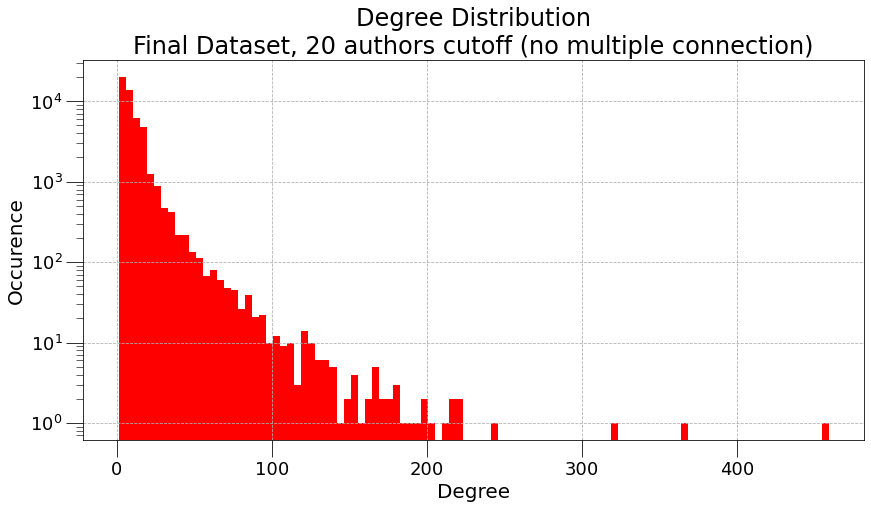

In [240]:
np.array([list(deg)[1] for deg in sample_graph.degree])

plt.figure(figsize=(14,7))

plt.title("Degree Distribution\nFinal Dataset, 20 authors cutoff (no multiple connection)", fontsize=24)

plt.hist(np.array([list(deg)[1] for deg in sample_graph.degree]), bins=101, color="red")

plt.xlabel("Degree", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/k_dist_from_realdata_no_weight.pdf",format="pdf",bbox_inches="tight")
plt.show()

This seems like that on log-log scale, a line could be fitted $\rightarrow$ **Power function** could be fitted.

**NOTE**: 

the little difference present in the two distributions are the following: in one, I allow multiple connections, in the other, networkx doesn't. Which one is correct? In my interpretation, it is allowed for diefferent authors to work together on multiple ocasions. Networkx's simple approach could be understood with the following argument: did they are work together or not. Of course, weighting the network would make it more visible which person worked with which more often, but we are only interested in the estabilishment of the connection!

## Graph Representation

It could be handy to see how it looks like with the spiral layout.

In [19]:
len(list(sample_graph.nodes))

48931

**This one runs for a long time**

In [23]:
#generate the positions of the spiral layout with initial 50 iterations
pos = nx.spring_layout(sample_graph)

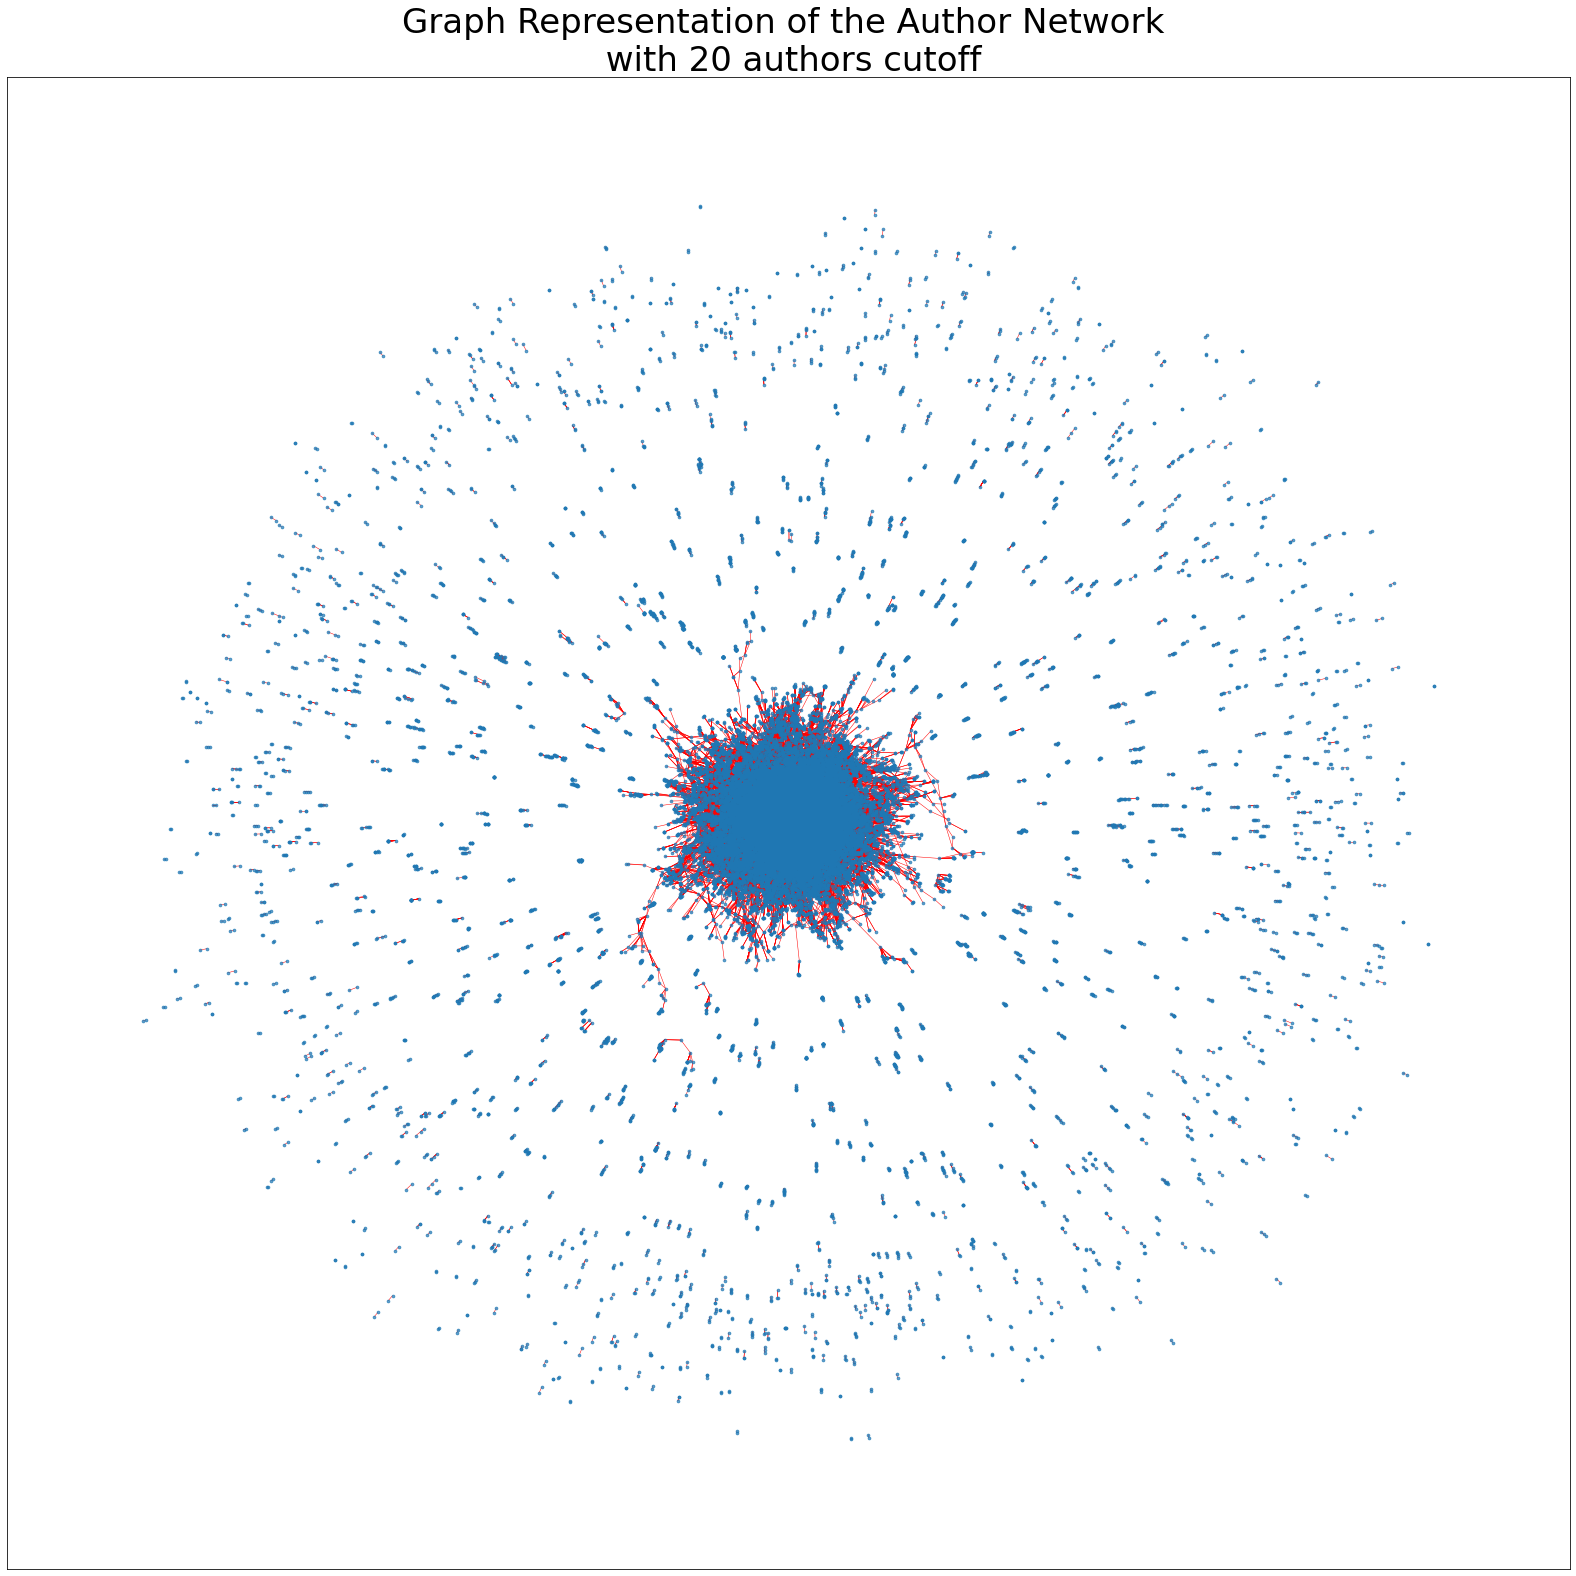

In [24]:
#get the figure
fig = plt.figure(figsize=(22,22))

plt.title("Graph Representation of the Author Network \n with 20 authors cutoff", fontsize=34)



nx.draw_networkx_nodes(sample_graph,
                      pos,
                      nodelist = np.array(sample_graph.nodes),
                      node_size=7,
                      alpha=0.7
                      )

nx.draw_networkx_edges(sample_graph,
                      pos,
                      width=0.5,
                      edgelist=tmp_lnk_lst[:,0:2],
                      edge_color='r',
                      arrows=False)

fig.tight_layout()

plt.savefig("figs/networkx_author_network_from_final.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

## Shortest distance

This seems to be tricky, because it calculates the `average_shortest_distance_path` for a graph or individually for each node.

In [20]:
test1 = nx.single_source_shortest_path_length(sample_graph,1)

In [21]:
p1,p2 = np.unique(list(test1.values()), return_counts=True)

In [22]:
p1*p2, np.mean(p1*p2)

(array([     0,      3,     40,    309,   2040,  14865,  81534, 105462,
         54528,  20799,   7700,   2486,   1164,    819,    420,    120,
            32], dtype=int64),
 17195.352941176472)

In [23]:
np.mean(list(test1.values()))

6.8639288062364985

So as it turns out, I was mistaken about the average shorted path calculation. p1 $\cdot$ p2  is almost correct, except that it should have been divided by sum(p2)... Of course It didn't make any sense. This makes the usage of numpy.unique obsilate.

In [24]:
count=0
for i in sample_graph.nodes:
    print(i)
    count+=1
    if count > 10:
        break

22082
13837
1833
21515
40369
30830
29942
8879
23127
37435
48635


As it seems, I have to do this for every node, make averages for each node and then a histogramm.

In [45]:
avg_container = []            #container for 
count = 0
print("\nStarting!")
for i in sample_graph.nodes:
    if ( count % 10 == 0):
        sys.stdout.write('\r@ {} / {}'.format(count,len(sample_graph.nodes)))
        sys.stdout.flush()
    
    node_n_length = nx.single_source_shortest_path_length(sample_graph,i)                  #get the path for a node
    #path_l, path_c = np.unique(list(node_n_length.values()), return_counts=True)          #get the lenghts and counts of lenght
    avg_container.append([i, np.mean(list(node_n_length.values()))])                       #save it for each node
    count+=1
    
print("\nFinished")

avg_shortest_path_local = np.array(avg_container)

#save it as it takes a huge amount of time to calculate
np.savetxt( "partial_results/avg_shortest_path_per_node.csv",avg_shortest_path_local,delimiter=",")


Starting!
@ 48930 / 48931
Finished


In [25]:
#load it in
avg_shortest_path_local = np.loadtxt("partial_results/avg_shortest_path_per_node.csv",delimiter="," )

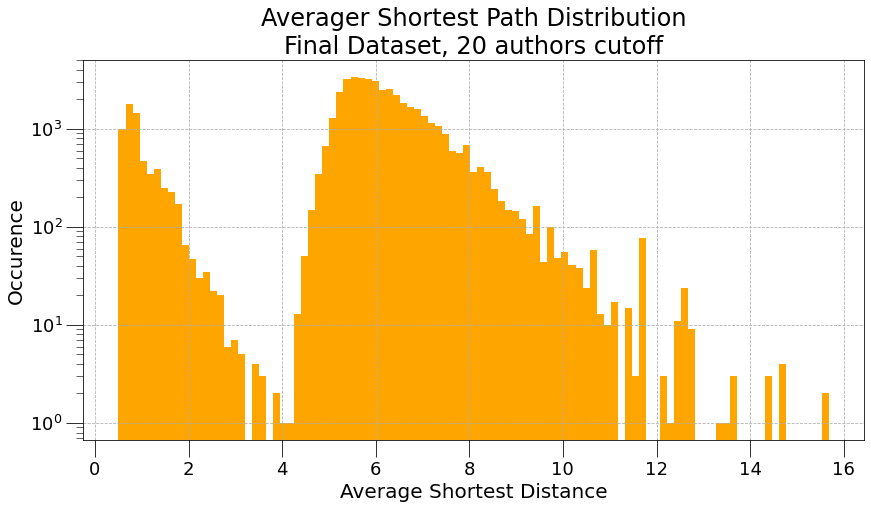

In [241]:
plt.figure(figsize=(14,7))

plt.title("Averager Shortest Path Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(avg_shortest_path_local[:,1], bins=101, color="orange")

plt.xlabel("Average Shortest Distance", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/avg_path_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

First breadth search could come handy to see why an avg. distance is such a high number for a given node. **Maybe take a look into it too**!

Seems to be very suspicious. Chains?

Let's take a look into what part of it comes from the giant component!

In [27]:
components = [c for c in sorted(nx.connected_components(sample_graph), key=len, reverse=True)]
#list(components[0])

In [38]:
giant_comp_avg_sh_paths = []
for i in list(components[0]):
    giant_comp_avg_sh_paths.append([i, avg_shortest_path_local[:,1][avg_shortest_path_local[:,0] == i ][0]])
    
giant_comp_avg_sh_paths = np.array(giant_comp_avg_sh_paths)

In [37]:
avg_shortest_path_local[:,1][avg_shortest_path_local[:,0] == 0]

array([7.65548981])

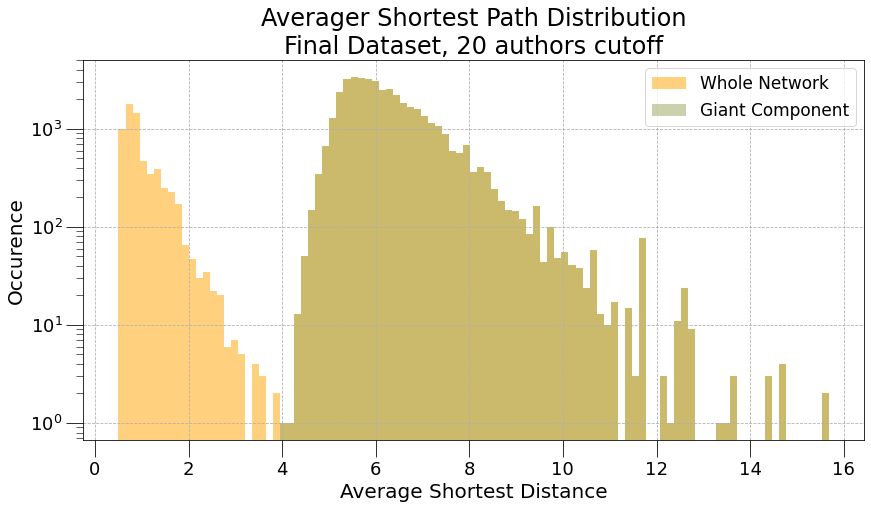

In [248]:
plt.figure(figsize=(14,7))

plt.title("Averager Shortest Path Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24) #title
 
_, bins0, _ = plt.hist(avg_shortest_path_local[:,1], bins=101, color="orange", label='Whole Network', alpha=0.5)  #whole network
plt.hist(giant_comp_avg_sh_paths[:,1], bins=bins0, color="#99a55a", label="Giant Component", alpha=0.5)          #just the giant component

plt.xlabel("Average Shortest Distance", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")            #log scale for easier comparison
plt.legend(loc='best', fontsize=17)
plt.grid(linestyle="--")

plt.savefig("figs/avg_path_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

### Breadth First Search

Let's take a look into why it looks like that! Let's use `single_source_shortest_path` to explain what's going on with this and use the highest avg. shortest path node as a source and see how long the paths are!

In [47]:
giant_comp_avg_sh_paths[:,0][giant_comp_avg_sh_paths[:,1] == np.max(giant_comp_avg_sh_paths[:,1])]

array([ 9120., 34081.])

In [48]:
sourced_shortest_paths = nx.single_source_shortest_path(sample_graph,source=9120)

In [54]:
sourced_shortest_paths_lengths = [len(i) for i in list(sourced_shortest_paths.values())]
print(np.max(sourced_shortest_paths_lengths))

26


**26**? It is a really long path. It seems like it do to these chains of nodes connecting to high degree nodes and then again to the chain. The first couple of nodes for each path are the same so this particular node is at the end of the chain!

## Components

Let's see what components are in in our network. We saw the graph representation, let's see the components that are present in it!.

In [49]:
comps = nx.number_connected_components(sample_graph)
print(comps)

1420


So we have 1422 components in it! Lot of small groups and on giant.

### Components sizes

Let's see their sizes and get the largest one too!

In [58]:
component_sizes = [len(c) for c in sorted(nx.connected_components(sample_graph), key=len, reverse=True)]

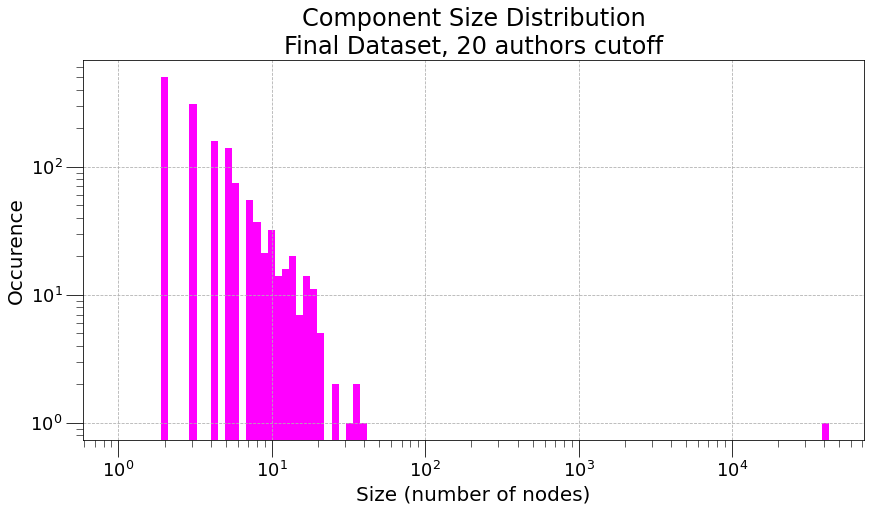

In [249]:
plt.figure(figsize=(14,7))

plt.title("Component Size Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(component_sizes, bins=np.logspace(np.log10(1),np.log10(max(component_sizes)), 101), color="magenta")

plt.xlabel("Size (number of nodes)", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/comp_size_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

### Smaller components in the graph

Let's see how these smaller components look like in the graph. First component is the giant one as I have it sorted before hand. I want to look at the second biggest component and 3 random ones.

In [175]:
components = [c for c in sorted(nx.connected_components(sample_graph), key=len, reverse=True)]
#can't give seed to choosen comps directly

choosen_comps = []
choosen_comps.append(list(components[1]))
large_enough = np.array(components[2:])[np.array(component_sizes[2:]) > 3 ]
for i in range(3):
    choosen_comps.append(list(np.random.choice(large_enough)))
    
#now I have to process these node to get edges
#will the data struct look ugly? YES TOTALLY

collector = [] #this will collect the individual results
for comp in choosen_comps:
    individual = np.zeros((0,2),dtype=np.uint32)
    #go through the the component's nodes
    for j in comp:
        edge_view = sample_graph.edges(j)
        for edge in edge_view:
            individual = np.append(individual, np.array([list(edge)]), axis=0)
    
    #cleaning
    for i in range(int(len(individual) / 2)):
        res = individual[i] == individual[:,::-1]   #compare one row to the others
        #if both columns has both true -> intersect -> see the true -> downsize
        individual = individual[~(res[:,0] * res[:,1] == True)]  
        #arguably this is not the best solution, but it does the trick!       
    
    collector.append(individual)
    
print("The {} components consist of: {}, {}, {}, {} bidirectional edges".format(len(collector),
                                                                                len(collector[0]),
                                                                                len(collector[1]),
                                                                               len(collector[2]),
                                                                               len(collector[3])))

The 4 components consist of: 150, 15, 21, 41 bidirectional edges


In [176]:
graph_set = []
positions = []

for comps in collector:
    G0 = nx.Graph()
    G0.add_edges_from(comps)
    graph_set.append(G0)
    
for graph in graph_set:
    positions.append(nx.spring_layout(graph))

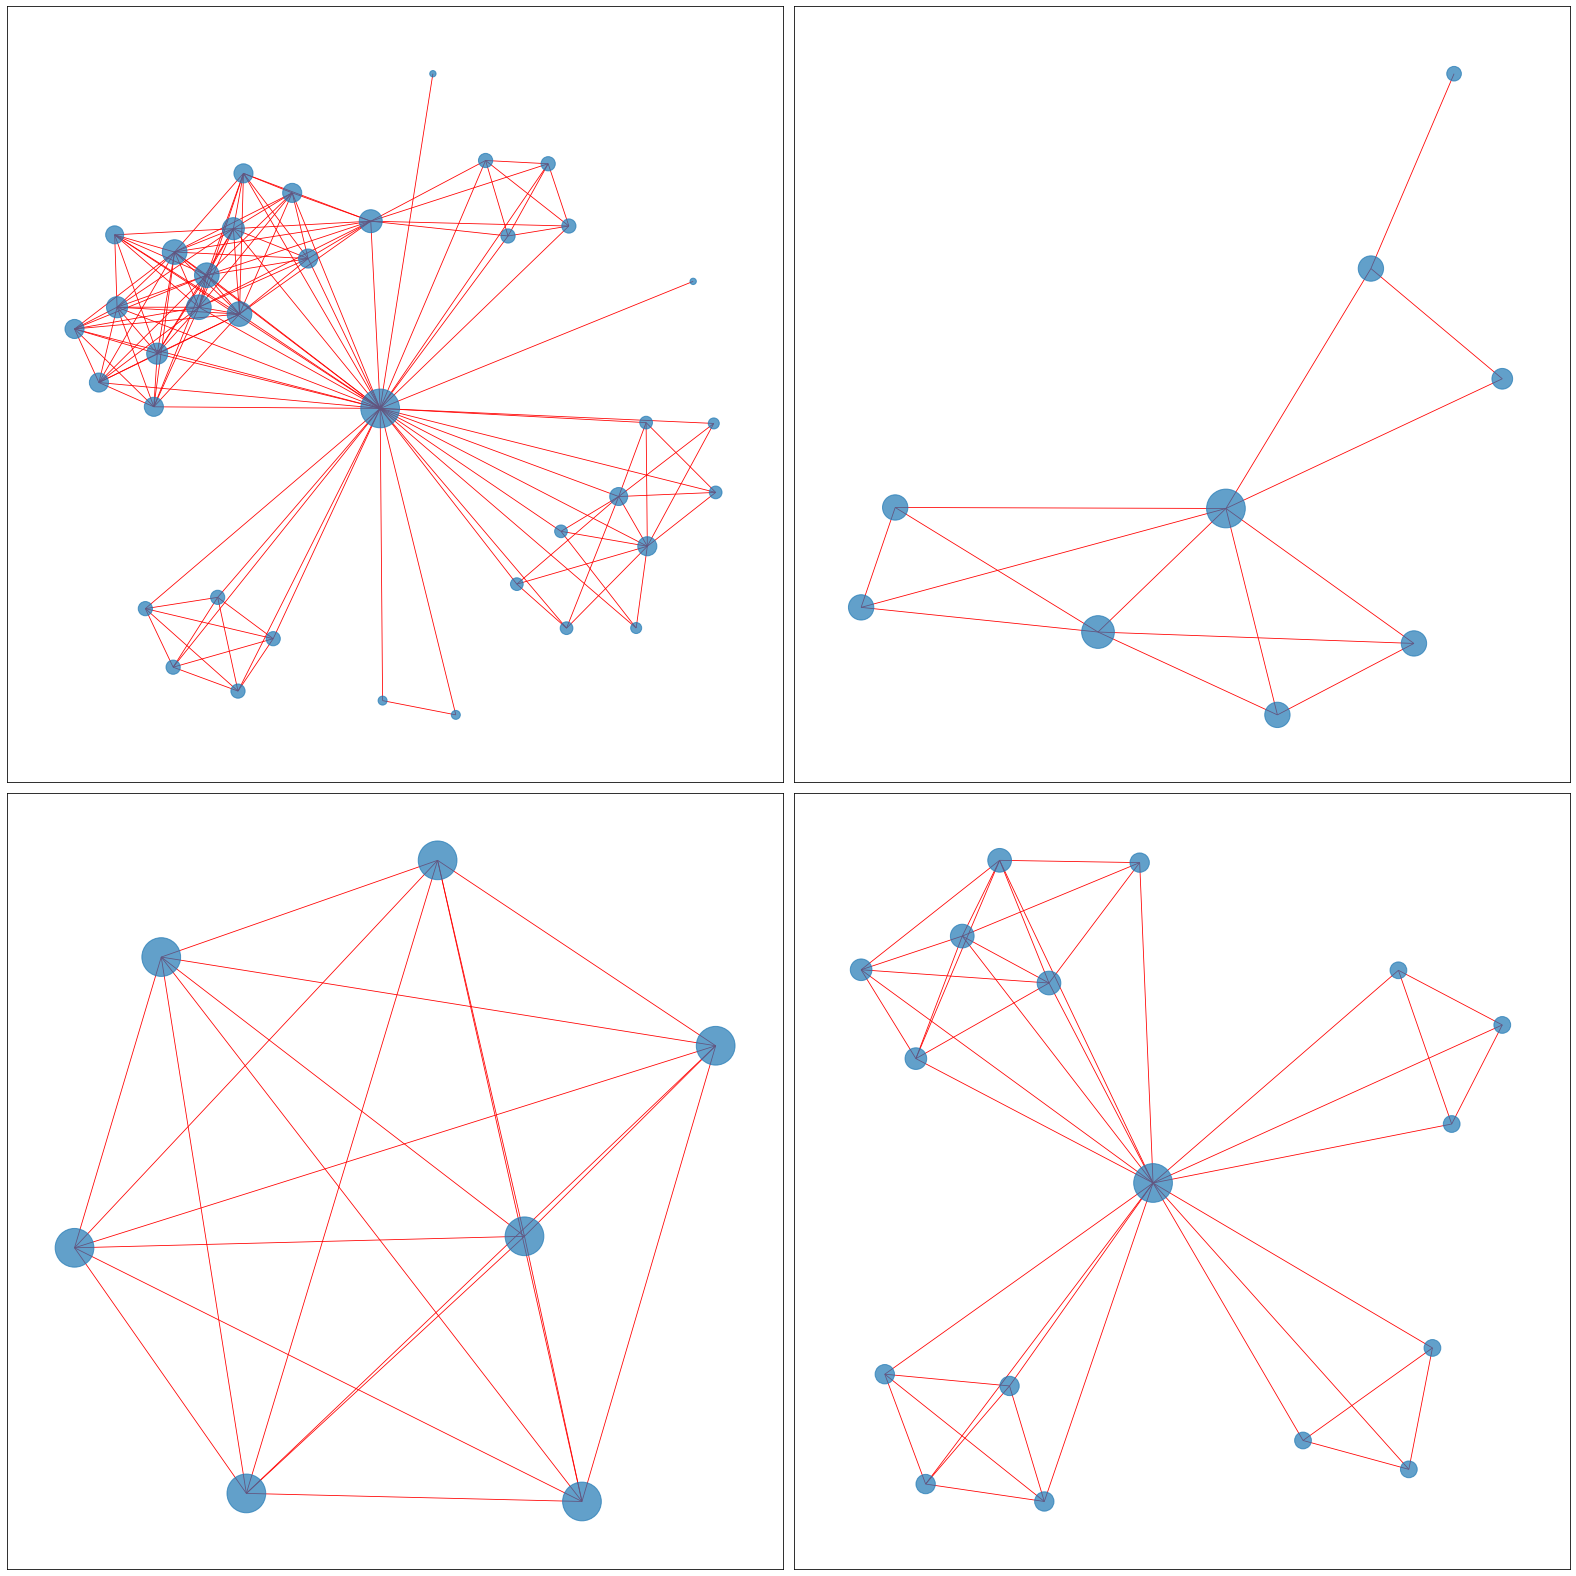

In [178]:
#get the figure
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(22,22))

#plt.title("Components Graph Representation of the Author Network \n with 20 authors cutoff", fontsize=34)

ax = axes.flatten()

for i in range(len(ax)):
    nx.draw_networkx_nodes(graph_set[i],
                          positions[i],
                          #nodelist = np.array(sample_graph.nodes),
                          node_size=(list([list(node_n_deg)[1] for node_n_deg in graph_set[i].degree])
                                     / 
                                     np.max(list([list(node_n_deg)[1] for node_n_deg in graph_set[i].degree]))) *1500,
                          alpha=0.7,
                          ax=ax[i])

    nx.draw_networkx_edges(graph_set[i],
                          positions[i],
                          width=0.8,
                          #edgelist=tmp_lnk_lst[:,0:2],
                          edge_color='r',
                          arrows=False,
                          ax=ax[i])

fig.tight_layout()

#plt.savefig("figs/component_representation.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

With these being cherry-picked to be shown, they seem to be a good candiates to show how the smaller components are structured.

## Small World

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.smallworld.sigma.html#networkx.algorithms.smallworld.sigma

Small World should be looked at the largest component!

**If someone looks at the results for the average shortest path distribution, it will be obvious that this network, or giant component of it does not have the small world property**

## Assortativity

It is advised to look into the assortativity of the giant component only as the little ones don't contribute to this as much and it will make the picture a bit more noisy.

The approach is straightforward: get the different degrees of the system, look through the linklist to see the nodes neightbours, and for a given node, save the sum of the degree of the node divided by the node of the degree. After that just sum up the distinct degree and partial results, and its done.

In [232]:
from scipy.optimize import curve_fit as curve_fit

In [332]:
def powerFunction(x,a,b):
    return b * np.power(x, -a)

def powlaw(x, a, b) :
    return a * np.power(x, b)
def linlaw(x, a, b) :
    return a + x * b

#https://stackoverflow.com/questions/41109122/fitting-a-curve-to-a-power-law-distribution-with-curve-fit-does-not-work
#it was very obvious that my fitting is not good, so the data has to be transoformed to fit on the linear one and back to what
#we actually need.

def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale"""
    # Weights according to a log scale
    # Apply fscalex
    xdata_log = np.log10(xdata)
    # Apply fscaley
    ydata_log = np.log10(ydata)
    # Fit linear
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    print(popt_log)
    # Apply fscaley^-1 to fitted data
    ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return (popt_log, pcov_log, ydatafit_log)

In [262]:
#go through the nodes, categorize them by their degree, take their neightbors degree average, save and sum up partial results
k_nn_partials = np.zeros((0,2))
count = 0
for node in components[0]:
    if(count % 10 == 0):
        sys.stdout.write("\r{} / {}".format(count,len(components[0])))
        sys.stdout.flush()
    #for each node, ge the degree
    deg = sample_graph.degree(node)
    n_degs = []
    #get its neighbours
    neighbours = [list(edge)[1] for edge in sample_graph.edges(node)]
    for neighbour in neighbours:
        n_degs.append(sample_graph.degree(neighbour))
    
    k_nn_partials = np.append(k_nn_partials, np.array([[deg,sum(n_degs)/deg]]), axis=0)
    count+=1
    
k_nn_partials = np.array(k_nn_partials)

degrees = np.unique(np.array([list(deg)[1] for deg in sample_graph.degree]))
k_nn_finals = np.zeros((0,2))
for deg in degrees:
    k_nn_finals = np.append(k_nn_finals, np.array([[deg, sum(np.array(k_nn_partials[:,1][k_nn_partials[:,0] == deg]))]]), axis=0)

42580 / 42588

[ 6.61270946 -2.25573501]


TypeError: can only concatenate str (not "numpy.float64") to str

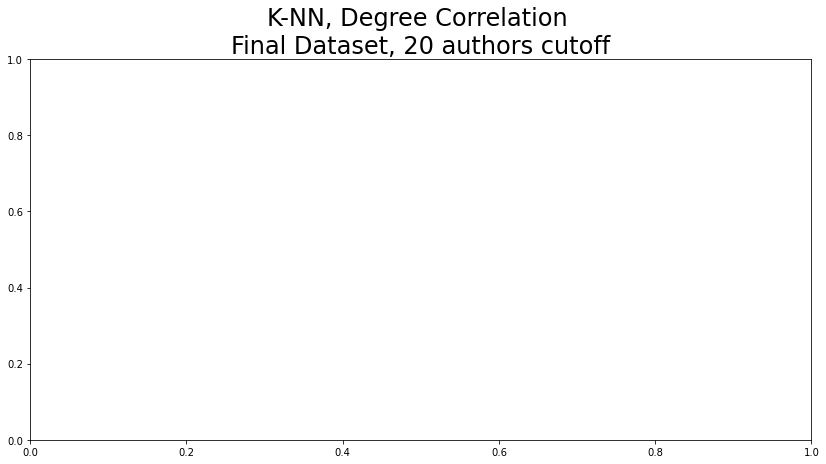

In [338]:
#curve_fit
#popt, pcov = curve_fit(powerFunction,k_nn_finals[:,0], k_nn_finals[:,1],p0 = np.asarray([-1,20**5]), maxfev=3000 )
popt_log, pcov_log, ydatafit_log = curve_fit_log(k_nn_finals[:,0],k_nn_finals[:,1])

#figure
plt.figure(figsize=(14,7))

plt.title("K-NN, Degree Correlation \nFinal Dataset, 20 authors cutoff", fontsize=24)

lab0 = "Fit: k$^{" + str(popt_log[1]() + "$"

plt.plot(k_nn_finals[:,0], k_nn_finals[:,1], " bo", label="Data")
plt.plot(k_nn_finals[:,0], ydatafit_log, "--r", label=lab0)


plt.xlabel("k (degree)", fontsize=20)
plt.ylabel("k$_{nn}$ (k)", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best", fontsize=17)
plt.grid(linestyle="--")

plt.savefig("figs/k_nn_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [179]:
!git add .
!git commit -m "2022/03/27: sub-stop"
!git push origin master

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[master e5125f7] 2022/03/27: sub-stop
 2 files changed, 195 insertions(+), 55 deletions(-)


To https://github.com/AdamGTaylor/ScientificModelling2021-2022-2
   ec04cc0..e5125f7  master -> master
